In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display as ipd
from glob import glob
import librosa
import seaborn as sns
import librosa.display
import cv2

from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [113]:
DATA_PATH = "./data/"

class conf:
    sampling_rate = 44100
    duration = 2 # sec
    hop_length = 347*duration # to make time steps 128
    fmin = 20
    fmax = sampling_rate // 2
    n_mels = 128
    n_fft = n_mels * 20
    padmode = 'constant'
    samples = sampling_rate * duration

In [114]:
df_train = pd.read_csv(DATA_PATH + "train.csv")
df_train.head()

,song_id,filename,filepath,genre_id,genre
0,10150,010150.ogg,train/010150.ogg,7,Instrumental
1,7358,007358.ogg,train/007358.ogg,2,Punk
2,20573,020573.ogg,train/020573.ogg,5,Folk
3,11170,011170.ogg,train/011170.ogg,12,Old-Time / Historic
4,16662,016662.ogg,train/016662.ogg,1,Rock


In [115]:
len(df_train)

19922

In [116]:
df_train[df_train.genre == "Punk"].sample()["filepath"].values[0]

'train/000128.ogg'

In [117]:
def get_genre_music_file(genre):
    return DATA_PATH + df_train[df_train.genre == genre].sample()["filepath"].values[0]

In [118]:
def read_audio(conf, pathname, trim_long_data):
    y, sr = librosa.load(pathname, sr=conf.sampling_rate)
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y) # trim, top_db=default(60)
    # make it unified length to conf.samples
    if len(y) > conf.samples: # long enough
        if trim_long_data:
            y = y[0:0+conf.samples]
    else: # pad blank
        padding = conf.samples - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, conf.samples - len(y) - offset), conf.padmode)
    return y

In [119]:
punk_music_file = get_genre_music_file("Punk")
audio = read_audio(conf, punk_music_file, True)
audio.shape

(88200,)

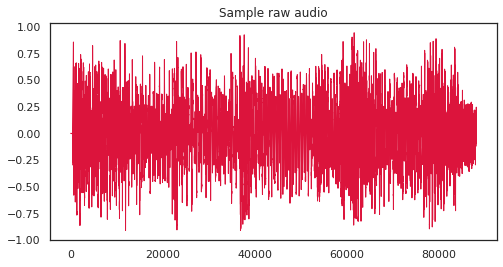

In [120]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(audio, 'crimson', lw=1)
ax.set_title("Sample raw audio")
plt.show()

In [121]:
y, sr = librosa.load(punk_music_file)
print(f"y: {y[:10]}")
print(f"y.shape = {y.shape}")
print(f"sr = {sr}")

y: [ 0.0000000e+00 -3.1931051e-17  2.0113278e-16 -5.0168194e-16
 -3.8802902e-16  1.4782670e-15 -1.0732380e-14  1.4059374e-14
 -2.7977898e-14  4.9722714e-15]
y.shape = (661560,)
sr = 22050


In [122]:
def audio_to_melspectrogram(conf, audio):
    spectrogram = librosa.feature.melspectrogram(y=audio, 
                                                 sr=conf.sampling_rate,
                                                 n_mels=conf.n_mels,
                                                 hop_length=conf.hop_length,
                                                 n_fft=conf.n_fft,
                                                 fmin=conf.fmin,
                                                 fmax=conf.fmax)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram

In [123]:
smel = audio_to_melspectrogram(conf, audio)
smel.shape

(128, 128)

In [124]:
def to_imagenet(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = (V - norm_min) / (norm_max - norm_min)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return np.stack([V]*3, axis=-1)

In [125]:
smel_img = to_imagenet(smel)
smel_img.shape

(128, 128, 3)

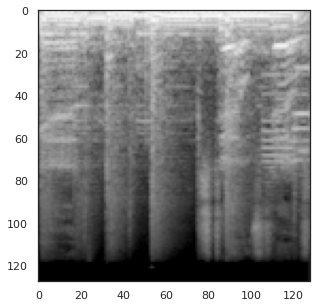

In [126]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(smel_img)

In [127]:
def visualize(genre):
    music_file = get_genre_music_file(genre)
    audio = read_audio(conf, music_file, True)
    S_mel = audio_to_melspectrogram(conf, audio)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
    # plot raw audio signal
    ax[0].plot(audio, lw=1)
    ax[0].set_title(f"{genre} raw signal")
    # plot mel spectrogram
    img = librosa.display.specshow(S_mel, x_axis="time", y_axis="mel", ax=ax[1])
    fig.colorbar(img, ax=ax[1])
    ax[1].set_title(f"{genre} mel spectrogram")

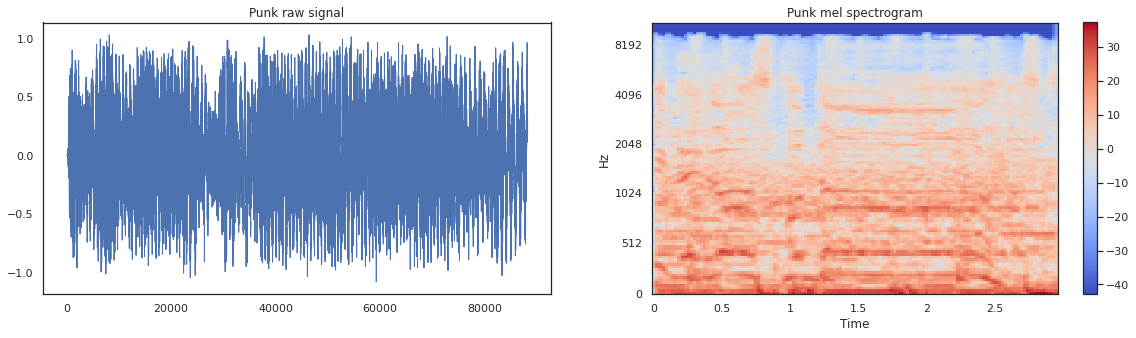

In [128]:
visualize("Punk")

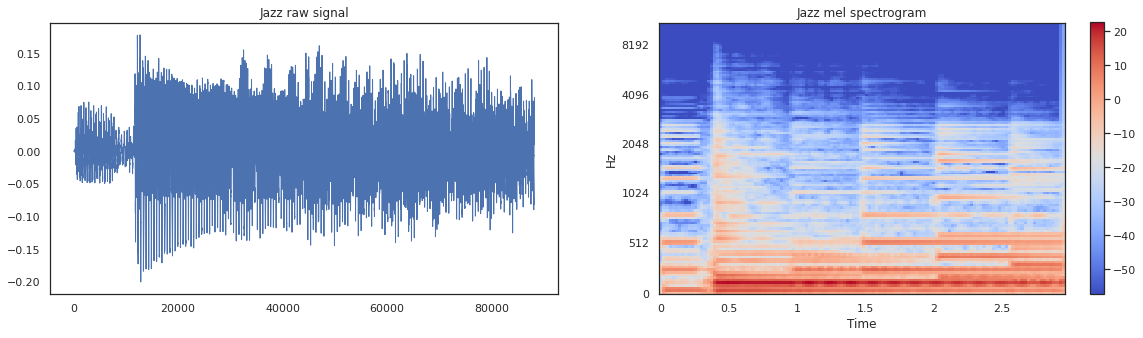

In [129]:
visualize("Jazz")

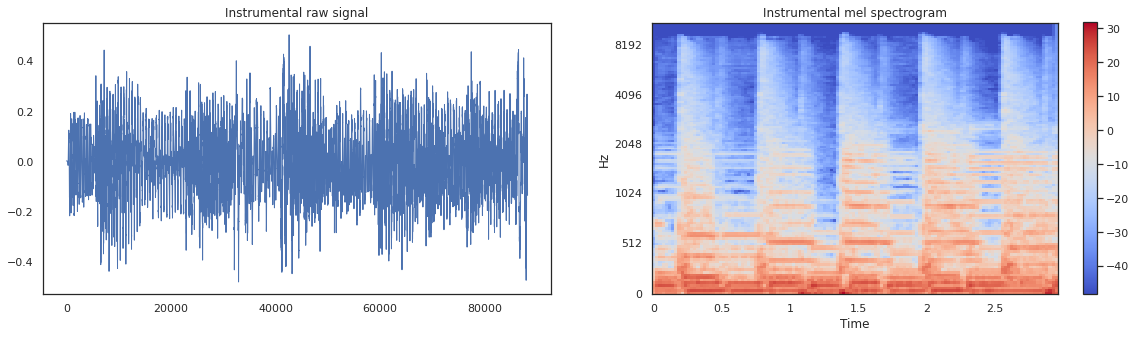

In [130]:
visualize("Instrumental")

In [131]:
audio_files = glob(DATA_PATH + "train/*.ogg")
audio_files[:10]

['./data/train/005999.ogg',
 './data/train/011949.ogg',
 './data/train/002373.ogg',
 './data/train/011585.ogg',
 './data/train/014276.ogg',
 './data/train/002562.ogg',
 './data/train/014714.ogg',
 './data/train/007491.ogg',
 './data/train/022393.ogg',
 './data/train/010669.ogg']

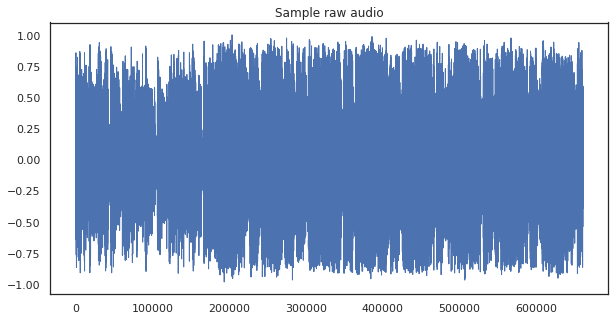

In [132]:
pd.Series(y).plot(figsize=(10, 5), lw=1, title="Sample raw audio")
plt.show()

In [133]:
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_db.shape

(1025, 1293)

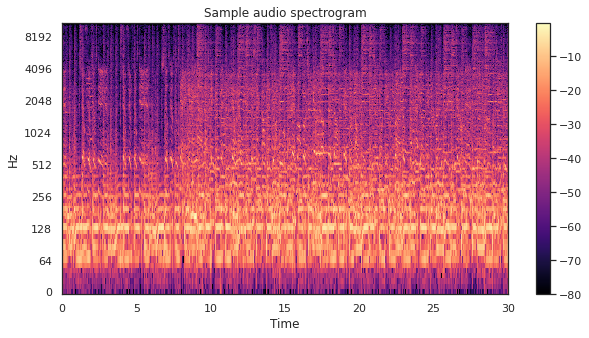

In [134]:
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(S_db, x_axis="time", y_axis="log", ax=ax)
ax.set_title("Sample audio spectrogram")
fig.colorbar(img, ax=ax)
plt.show()

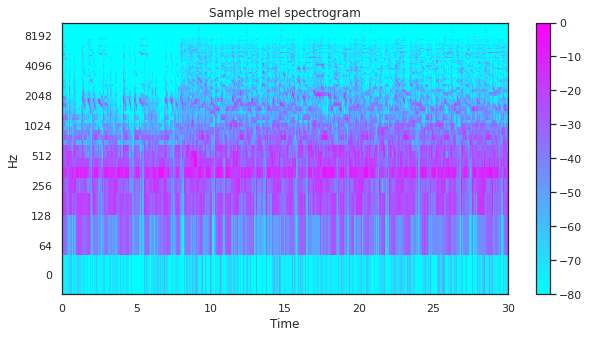

In [135]:
S_mel = librosa.feature.melspectrogram(y=y, sr=sr)
S_mel_db = librosa.amplitude_to_db(S_mel, ref=np.max)
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(S_mel_db, x_axis="time", y_axis="log", cmap="cool", ax=ax)
ax.set_title("Sample mel spectrogram")
fig.colorbar(img, ax=ax)
plt.show()

In [136]:
def bar_plot(values, labels, ylabel, xlabel, title):    
    fig, ax = plt.subplots(figsize=(14, 6))
    sns.set_theme(style="whitegrid")
    bars = ax.bar(labels, values)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.xticks(rotation=90)
    # add the y value on top of each bar
    for bar in bars:
        y_val = bar.get_height()
        plt.text(bar.get_x(), y_val+0.05, y_val)    
    ax = sns.barplot(y=values, x=labels, ax=ax)    

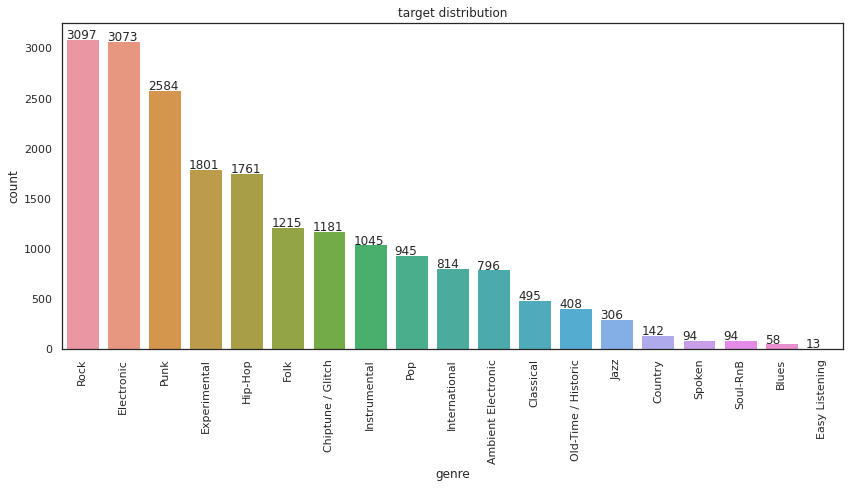

In [137]:
target_counts = df_train.genre.value_counts()
bar_plot(target_counts.values, target_counts.index, ylabel="count", xlabel="genre", title="target distribution")

In [138]:
df_train.head()

,song_id,filename,filepath,genre_id,genre
0,10150,010150.ogg,train/010150.ogg,7,Instrumental
1,7358,007358.ogg,train/007358.ogg,2,Punk
2,20573,020573.ogg,train/020573.ogg,5,Folk
3,11170,011170.ogg,train/011170.ogg,12,Old-Time / Historic
4,16662,016662.ogg,train/016662.ogg,1,Rock


In [139]:
my_str = "train/010150.ogg"
my_str[6:-4]

'010150'

In [140]:
def audio_to_img(file_path):
    filename_no_ext = file_path[6:-4]
    file_path = DATA_PATH + file_path
    smel_np_path = DATA_PATH + "processed_train/" + filename_no_ext + ".npy"
    smel_img_path = DATA_PATH + "processed_train/" + filename_no_ext + ".png"
    audio = read_audio(conf, file_path, True)
    S_mel = audio_to_melspectrogram(conf, audio)
    S_mel_img = to_imagenet(S_mel)
    np.save(smel_np_path, S_mel_img)
    cv2.imwrite(smel_img_path, S_mel_img)
    return file_path

In [141]:
df_train_blues = df_train[df_train.genre == "Easy Listening"]
df_train_blues.filepath.map(lambda item: audio_to_img(item))

224      ./data/train/002549.ogg
3683     ./data/train/020407.ogg
5766     ./data/train/001239.ogg
5966     ./data/train/007795.ogg
6652     ./data/train/019765.ogg
10498    ./data/train/008897.ogg
12477    ./data/train/002643.ogg
12752    ./data/train/017475.ogg
13060    ./data/train/013702.ogg
13227    ./data/train/023369.ogg
15725    ./data/train/020462.ogg
18010    ./data/train/000952.ogg
18476    ./data/train/020445.ogg
Name: filepath, dtype: object

In [2]:
file_path = "/data/train/002549.ogg"
file_path.split("/")[-1].split(".")[0]

'002549'